# Images alignment on S3/S2

This notebook presents some examples of imagery alignment techniques introduced in the previous notebook on the real-life example of aligning Sentinel-2 and Sentinel-3 OLCI imagery.

## Load in data needed

In [1]:
import numpy as np
import matplotlib.pyplot as plt

save_path = '/content/drive/MyDrive/GEOL0069/2425/Week 5/Regression_application'
s2_data = np.load(save_path+'/s2_zoomed_data.npz')
s2_x = s2_data['x']
s2_y = s2_data['y']
s2_band_data = s2_data['band_data']

s3_data = np.load(save_path+'/s3_zoomed_data.npz')
s3_x = s3_data['x']
s3_y = s3_data['y']
s3_reflectance = s3_data['reflectance']



You don't need to run this cell. This cell mainly interpolates the loaded S3/S2 scene to a common grid for alignment.
```python
import numpy as np
from scipy.interpolate import griddata

def process_and_save_data(
    x_s2, y_s2, s2_band_data, s2_band_index,
    x_s3, y_s3, s3_reflectance, s3_band_index,
    ngrid=400, out_file='interpolated_data.npz'
):
    # Pick single band
    s2_vals = s2_band_data[:, s2_band_index]
    s3_vals = s3_reflectance[:, s3_band_index]

    x_min = min(x_s3.min(), x_s2.min())
    x_max = max(x_s3.max(), x_s2.max())
    y_min = min(y_s3.min(), y_s2.min())
    y_max = max(y_s3.max(), y_s2.max())

    x_grid = np.linspace(x_min, x_max, ngrid)
    y_grid = np.linspace(y_min, y_max, ngrid)
    xg, yg = np.meshgrid(x_grid, y_grid)

    z_s2 = griddata((x_s2, y_s2), s2_vals, (xg, yg), method='cubic')
    z_s3 = griddata((x_s3, y_s3), s3_vals, (xg, yg), method='cubic')

    np.savez_compressed(out_file, xg=xg, yg=yg, z_s2=z_s2, z_s3=z_s3)
    print(f"Saved precomputed arrays to '{out_file}'")

process_and_save_data(
    s2_x, s2_y, s2_band_data, 0,
    s3_x, s3_y, s3_reflectance, 0,
    ngrid=400,
    out_file='/content/drive/MyDrive/GEOL0069/2324/Week 6 2025/interpolated_data.npz'
)

```

In [2]:
def load_precomputed_data(file='interpolated_data.npz'):
    data = np.load(file)
    xg = data['xg']
    yg = data['yg']
    z_s2 = data['z_s2']
    z_s3 = data['z_s3']
    print(f"Loaded arrays from '{file}' (shapes: {z_s2.shape}, {z_s3.shape})")
    return xg, yg, z_s2, z_s3


xg, yg, z_s2, z_s3 = load_precomputed_data('/content/drive/MyDrive/GEOL0069/2324/Week 6 2025/interpolated_data.npz')


Loaded arrays from '/content/drive/MyDrive/GEOL0069/2324/Week 6 2025/interpolated_data.npz' (shapes: (400, 400), (400, 400))


## Auto-correlation

[AutoCorr] Manual shift=(10,-5), Recovered=(12,-7)


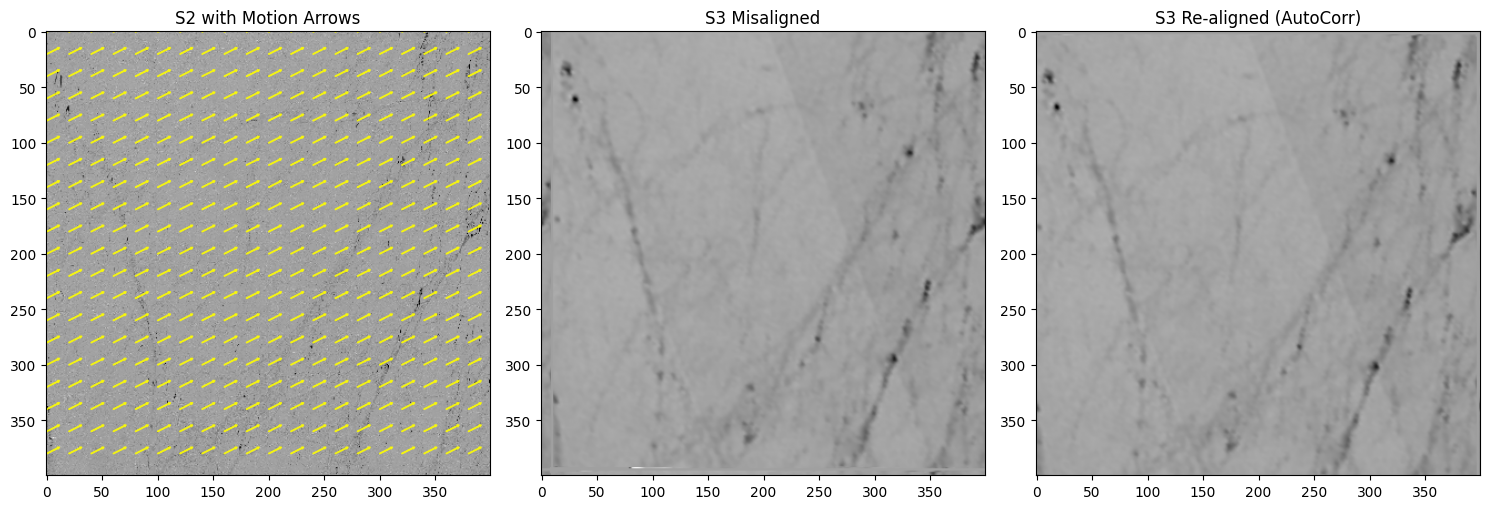

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrow
from scipy.signal import correlate2d

def auto_corr_demo_with_arrows(
    z_s2, z_s3,
    manual_dx=15,
    manual_dy=-7,
    step=20
):
    A = np.nan_to_num(z_s2, nan=np.nanmean(z_s2))
    B = np.nan_to_num(z_s3, nan=np.nanmean(z_s3))

    B_misaligned = np.roll(np.roll(B, manual_dy, axis=0), manual_dx, axis=1)

    corr = correlate2d(A, B_misaligned, mode='same', boundary='wrap')
    peak_y, peak_x = np.unravel_index(np.argmax(corr), corr.shape)

    shift_x_btoa = peak_x - B_misaligned.shape[1]//2
    shift_y_btoa = peak_y - B_misaligned.shape[0]//2

    dx_est = -shift_x_btoa
    dy_est = -shift_y_btoa

    print(f"[AutoCorr] Manual shift=({manual_dx},{manual_dy}), Recovered=({dx_est},{dy_est})")

    B_realigned = np.roll(np.roll(B_misaligned, shift_y_btoa, axis=0),
                          shift_x_btoa, axis=1)

    fig, (axA, axB, axC) = plt.subplots(1, 3, figsize=(15, 5))

    axA.imshow(A, cmap='gray')
    axA.set_title("S2 with Motion Arrows")

    h, w = A.shape
    rows = np.arange(0, h, step)
    cols = np.arange(0, w, step)

    for r in rows:
        for c in cols:
            axA.add_patch(FancyArrow(c, r, manual_dx, manual_dy, color="yellow",
                                     width=0.5, head_width=2, head_length=2, alpha=0.8))

    axB.imshow(B_misaligned, cmap='gray')
    axB.set_title("S3 Misaligned")

    axC.imshow(B_realigned, cmap='gray')
    axC.set_title("S3 Re-aligned (AutoCorr)")

    plt.tight_layout()
    plt.show()

# Example usage:
auto_corr_demo_with_arrows(z_s2, z_s3, manual_dx=10, manual_dy=-5, step=20)


## Phase correlation

[PhaseCorr] Manual shift=(10,-5), Recovered=(11.00,-7.00)


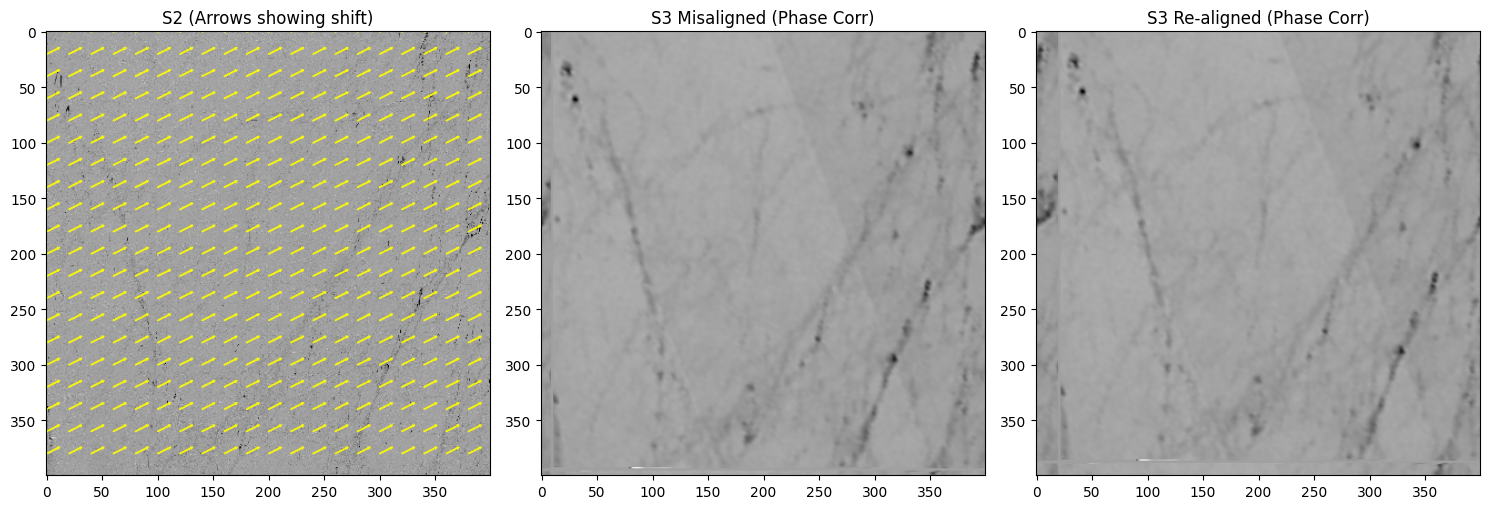

In [7]:
from skimage.registration import phase_cross_correlation


def phase_corr_demo_with_arrows(
    z_s2, z_s3,
    manual_dx=15,
    manual_dy=-7,
    step=20
):
    A = np.nan_to_num(z_s2, nan=np.nanmean(z_s2))
    B = np.nan_to_num(z_s3, nan=np.nanmean(z_s3))

    B_misaligned = np.roll(np.roll(B, manual_dy, axis=0), manual_dx, axis=1)

    shift, error, diffphase = phase_cross_correlation(A, B_misaligned)
    dy_est, dx_est = shift
    dx_est, dy_est = -dx_est, -dy_est
    print(f"[PhaseCorr] Manual shift=({manual_dx},{manual_dy}), Recovered=({dx_est:.2f},{dy_est:.2f})")

    B_realigned = np.roll(np.roll(B_misaligned, int(dy_est), axis=0),
                          int(dx_est), axis=1)

    fig, (axA, axB, axC) = plt.subplots(1,3, figsize=(15,5))

    axA.imshow(A, cmap='gray')
    axA.set_title(f"S2 (Arrows showing shift)")
    h, w = A.shape
    rows = np.arange(0, h, step)
    cols = np.arange(0, w, step)
    for r in rows:
        for c in cols:
            axA.add_patch(FancyArrow(c, r, manual_dx, manual_dy, color="yellow",
                                     width=0.5, head_width=2, head_length=2, alpha=0.8))

    axB.imshow(B_misaligned, cmap='gray')
    axB.set_title("S3 Misaligned (Phase Corr)")

    axC.imshow(B_realigned, cmap='gray')
    axC.set_title("S3 Re-aligned (Phase Corr)")

    plt.tight_layout()
    plt.show()

phase_corr_demo_with_arrows(z_s2, z_s3, manual_dx=10, manual_dy=-5, step=20)


## ECC (Enhanced Correlation Coefficient) Alignment

[ECC] Manual shift=(10,-5), Recovered=(10.94,-7.87), CC=0.7336


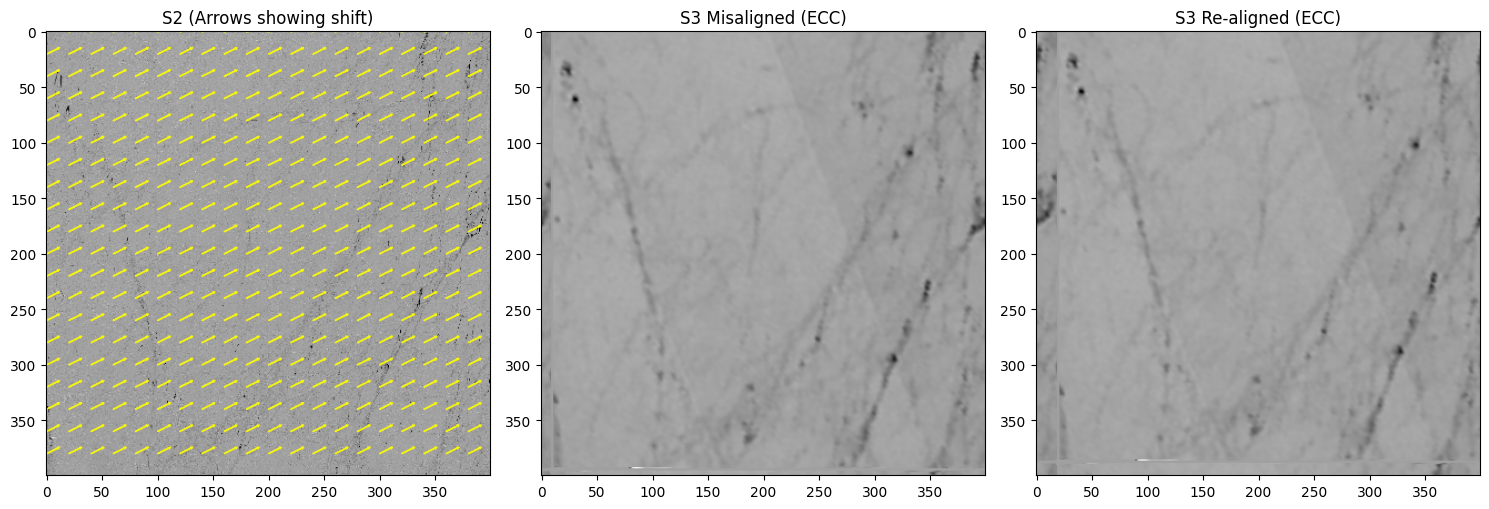

In [5]:

import cv2


def ecc_demo_with_arrows(
    z_s2, z_s3,
    manual_dx=15,
    manual_dy=-7,
    step=20,
    iterations=200,
    eps=1e-6
):
    A = np.nan_to_num(z_s2, nan=np.nanmean(z_s2)).astype(np.float32)
    B = np.nan_to_num(z_s3, nan=np.nanmean(z_s3)).astype(np.float32)

    B_misaligned = np.roll(np.roll(B, manual_dy, axis=0), manual_dx, axis=1)

    warp_matrix = np.eye(2, 3, dtype=np.float32)
    criteria = (cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, iterations, eps)

    try:
        cc, warp_matrix = cv2.findTransformECC(A, B_misaligned, warp_matrix, motionType=cv2.MOTION_TRANSLATION, criteria=criteria)
        dx_est, dy_est = warp_matrix[0,2], warp_matrix[1,2]
        print(f"[ECC] Manual shift=({manual_dx},{manual_dy}), Recovered=({dx_est:.2f},{dy_est:.2f}), CC={cc:.4f}")
    except cv2.error as e:
        print("[ECC Failed]", e)
        dx_est, dy_est = None, None

    B_realigned = np.roll(np.roll(B_misaligned, int(dy_est), axis=0),
                          int(dx_est), axis=1)

    fig, (axA, axB, axC) = plt.subplots(1,3, figsize=(15,5))

    axA.imshow(A, cmap='gray')
    axA.set_title(f"S2 (Arrows showing shift)")
    h, w = A.shape
    rows = np.arange(0, h, step)
    cols = np.arange(0, w, step)
    for r in rows:
        for c in cols:
            axA.add_patch(FancyArrow(c, r, manual_dx, manual_dy, color="yellow",
                                     width=0.5, head_width=2, head_length=2, alpha=0.8))

    axB.imshow(B_misaligned, cmap='gray')
    axB.set_title("S3 Misaligned (ECC)")

    axC.imshow(B_realigned, cmap='gray')
    axC.set_title("S3 Re-aligned (ECC)")

    plt.tight_layout()
    plt.show()

ecc_demo_with_arrows(z_s2, z_s3, manual_dx=10, manual_dy=-5, step=20)


## Sea ice drift algorithm

Nansen Centre has developed a sea ice drift tracking algorithm based on 'Feature tracking' for Sentinel-1 SAR images. For more information, please have a look at this [link](https://github.com/nansencenter/sea_ice_drift).

